# Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей.

## 1) Текстовое описание набора данных

В качестве набора данных мы будем использовать набор данных 
о ценах на жилье в Бостоне - https://archive.ics.uci.edu/ml/machine-learning-databases/housing/

В качестве задачи, которую должна решать модель, выберем задачу регрессии
Датасет состоит из файла:
- housing.data - обучающая выборка (в этом примере используется только данный файл)

Файл содержит следующие колонки:
- CRIM - уровень преступности на душу населения в разбивке по городам.
- ZN - доля жилой земли, зонированной на участки площадью более 25 000 кв.футов.
- INDUS - доля акров, не связанных с розничной торговлей, на город.
- CHAS - Фиктивная переменная реки Чарльз (= 1, если тракт ограничивает реку; 0 в противном случае).
- NOX - концентрация оксидов азота (частей на 10 миллионов).
- RM - среднее количество комнат в жилом помещении.
- AGE - доля жилых помещений, занятых владельцами, построенных до 1940 года.
- DIS - взвешенные расстояния до пяти бостонских центров занятости.
- RAD - индекс доступности к радиальным магистралям.
- TAX - ставка налога на недвижимость с полной стоимостью за 10 000 долларов США.
- PTRATIO - соотношение учащихся и учителей в разбивке по городам.
- B - 1000(Bk - 0,63)^2, где Bk - доля чернокожих по городам.
- LSTAT - % более низкий статус населения.
- MEDV - средняя стоимость домов, занятых владельцами, в 1000 долларов.

### Импорт библиотек

In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, ShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score 
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.datasets import *
sns.set(style="ticks")

### Загрузка данных

Загрузим файлы датасета из библиатеке `sklearn.datasets`, и преобразуем в `DataFrame` библиотеки *Pandas*.


In [10]:
ds = load_boston()
df = pd.DataFrame(data= np.c_[ds['data'], ds['target']],
                 columns= list(ds['feature_names']) + ['target'])
df.count()

CRIM       506
ZN         506
INDUS      506
CHAS       506
NOX        506
RM         506
AGE        506
DIS        506
RAD        506
TAX        506
PTRATIO    506
B          506
LSTAT      506
target     506
dtype: int64

### Подготовка данных

Поделим данные на тестовую и тренеровочную выборку в пропорции 1 к 4

In [97]:
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(
    df.drop(columns='target'), df['target'], test_size=0.2, random_state=5060)

### В качестве метрик для решения задачи регрессии будем использовать:

#### [Mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error) - средняя абсолютная ошибка

$MAE(y,\hat{y}) = \frac{1}{N} \cdot \sum\limits_{i=1}^N \lvert  y_i - \hat{y_i} \rvert $

где:
- $y$ - истинное значение целевого признака
- $\hat{y}$ - предсказанное значение целевого признака
- $N$ - размер тестовой выборки

Чем ближе значение к нулю, тем лучше качество регрессии.

Основная проблема метрики состоит в том, что она не нормирована.

Вычисляется с помощью функции [mean_absolute_error.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error)

#### [Mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) - средняя квадратичная ошибка

$MSE(y,\hat{y}) = \frac{1}{N} \cdot \sum\limits_{i=1}^N ( y_i - \hat{y_i} )^2 $

где:
- $y$ - истинное значение целевого признака
- $\hat{y}$ - предсказанное значение целевого признака
- $N$ - размер тестовой выборки

Вычисляется с помощью функции [mean_squared_error.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error)

#### [Метрика $R^2$ или коэффициент детерминации](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%B4%D0%B5%D1%82%D0%B5%D1%80%D0%BC%D0%B8%D0%BD%D0%B0%D1%86%D0%B8%D0%B8) 

$R^2(y,\hat{y}) = 1 - \frac{\sum\limits_{i=1}^N ( y_i - \hat{y_i} )^2}{\sum\limits_{i=1}^N ( y_i - \overline{y_i} )^2} $

где:
- $y$ - истинное значение целевого признака
- $\hat{y}$ - предсказанное значение целевого признака
- $N$ - размер тестовой выборки
- $\overline{y_i} = \frac{1}{N} \cdot \sum\limits_{i=1}^N y_i $

Вычисляется с помощью функции [r2_score.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score)

#### [Median absolute error](https://en.wikipedia.org/wiki/Median_absolute_deviation)

$MedAE(y,\hat{y})=median(| y_1 - \hat{y_1} |, \cdot, | y_N - \hat{y_N} |) $

Метрика интересна тем, что является устойчивой к выбросам в данных.

Вычисляется с помощью функции [median_absolute_error.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.median_absolute_error)

### Обучем модель ближайщих соседей с K = 5

Создадим функции расчёта метрик и будем их сохранять в словарь

In [98]:
results = dict()

In [99]:
def calculate_result(n_neighbors, df_X_train, df_X_test, df_y_train, df_y_test):
    knn_regr = KNeighborsRegressor(n_neighbors=n_neighbors)
    knn_regr.fit(df_X_train, df_y_train)
    
    knn_regr_prediction = knn_regr.predict(df_X_test)
    
    results['mean_absolute k = {}'.format(n_neighbors)] = mean_absolute_error(df_y_test, knn_regr_prediction)
    results['mean_squared k = {}'.format(n_neighbors)] = mean_squared_error(df_y_test, knn_regr_prediction)
    results['median_absolute k = {}'.format(n_neighbors)] = median_absolute_error(df_y_test, knn_regr_prediction)
    results['r2_score k = {}'.format(n_neighbors)] = r2_score(df_y_test, knn_regr_prediction)
    

In [100]:
calculate_result(5, df_X_train, df_X_test, df_y_train, df_y_test)

In [101]:
print(results)

{'mean_absolute k = 5': 4.197647058823529, 'mean_squared k = 5': 37.54883137254902, 'median_absolute k = 5': 2.959999999999999, 'r2_score k = 5': 0.5365764151848202}


### Проведём кросс-валидацию для текущего гипер параметра k = 5

Будем использовать следующие стратегии кросс-валидации: [K-fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold),
[Repeated K-Fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html#sklearn.model_selection.RepeatedKFold),
[ShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit).
                    

Создадим схожую функцию для расчётов и зададим интересующие нас метрики

In [113]:
scoring = {'mean_absolute': make_scorer(mean_absolute_error), 
           'mean_squared': make_scorer(mean_squared_error),
           'median_absolute': make_scorer(median_absolute_error),
           'r2_score':make_scorer(r2_score)}
validation_results = dict()

In [114]:
def calculate_validation(n_neighbors, df_X, df_y, strategy, name_strategy):
    scores = cross_validate(KNeighborsRegressor(n_neighbors=n_neighbors), 
                        df_X, df_y, scoring=scoring, 
                        cv=strategy)
    for key in scoring.keys():
        scores['mean_' + key] = np.mean(scores['test_'+key])
    validation_results[name_strategy] = scores
    print(scores)
    

In [115]:
calculate_validation(5, df.drop(columns='target'), df['target'], KFold(n_splits=5), 'kfold')
calculate_validation(5, df.drop(columns='target'), df['target'], RepeatedKFold(n_splits=3, n_repeats=2), 'repeat_kfold')
calculate_validation(5, df.drop(columns='target'), df['target'], ShuffleSplit(n_splits=5, test_size=0.2), 'shuffleSplit')

{'fit_time': array([0.01750541, 0.0160048 , 0.01098919, 0.01294971, 0.01888275]), 'score_time': array([0.01654553, 0.01303792, 0.01279807, 0.012712  , 0.01300097]), 'test_mean_absolute': array([6.51980392, 5.7039604 , 7.65287129, 6.09188119, 4.11346535]), 'test_mean_squared': array([ 72.84204314,  77.44044752, 114.19790495,  89.00506931,
        31.22948515]), 'test_median_absolute': array([5.85, 3.8 , 4.82, 3.92, 2.58]), 'test_r2_score': array([-1.10921186,  0.14934963, -0.4259195 , -0.01474393, -0.17455668]), 'mean_mean_absolute': 6.016396427878083, 'mean_mean_squared': 76.9429900135896, 'mean_median_absolute': 4.194000000000002, 'mean_r2_score': -0.31501646812514134}
{'fit_time': array([0.00700259, 0.00604558, 0.00499511, 0.00296402, 0.00394297,
       0.00295353]), 'score_time': array([0.0072341 , 0.00695586, 0.00368404, 0.00500274, 0.00404644,
       0.00404477]), 'test_mean_absolute': array([4.45621302, 4.2295858 , 4.63083333, 4.00556213, 4.97502959,
       4.19904762]), 'test_me

In [105]:
scoring.keys()

dict_keys(['mean_absolute', 'mean_squared', 'median_absolute', 'r2_score'])

### Поиск гипперпараметров

#### [Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) (решетчатый поиск)

In [106]:
n_range = np.array(range(1,62,1))
tuned_parameters = [{'n_neighbors': n_range}]
clf_gs = GridSearchCV(KNeighborsRegressor(), tuned_parameters, cv=5, scoring='neg_mean_squared_error')
clf_gs.fit(df_X_train, df_y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61])}],
             scoring='neg_mean_squared_error')

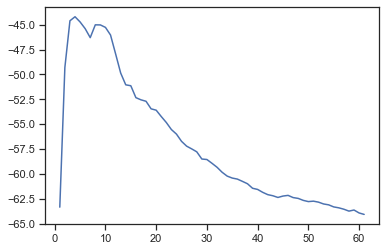

In [107]:
plt.plot(n_range, clf_gs.cv_results_['mean_test_score'])

In [108]:
clf_gs.best_params_

{'n_neighbors': 4}

### Проверка гипперпараметра

In [110]:
calculate_result(4, df_X_train, df_X_test, df_y_train, df_y_test)

In [116]:
calculate_validation(4, df.drop(columns='target'), df['target'], KFold(n_splits=5), 'kfold_4')
calculate_validation(4, df.drop(columns='target'), df['target'], RepeatedKFold(n_splits=3, n_repeats=2), 'repeat_kfold_4')
calculate_validation(4, df.drop(columns='target'), df['target'], ShuffleSplit(n_splits=5, test_size=0.2), 'shuffleSplit_4')

{'fit_time': array([0.0029974 , 0.00399923, 0.0044446 , 0.00296879, 0.00296474]), 'score_time': array([0.00408411, 0.00296283, 0.00300455, 0.00403118, 0.00402403]), 'test_mean_absolute': array([6.67132353, 5.60742574, 7.74158416, 5.98811881, 4.0019802 ]), 'test_mean_squared': array([ 74.82303309,  74.61106436, 115.04418317,  88.33102723,
        31.20767327]), 'test_median_absolute': array([5.45 , 3.575, 5.6  , 3.85 , 2.75 ]), 'test_r2_score': array([-1.16657334,  0.1804292 , -0.43648646, -0.0070592 , -0.17373632]), 'mean_mean_absolute': 6.00208648806057, 'mean_mean_squared': 76.80339622160744, 'mean_median_absolute': 4.244999999999999, 'mean_r2_score': -0.320685224628445}
{'fit_time': array([0.00299954, 0.00400281, 0.00399971, 0.00299859, 0.00403786,
       0.00400329]), 'score_time': array([0.00399876, 0.00399876, 0.00300145, 0.00400019, 0.00396228,
       0.00503302]), 'test_mean_absolute': array([4.62751479, 4.31553254, 4.41577381, 3.8989645 , 4.7010355 ,
       4.42797619]), 'test

In [111]:
results

{'mean_absolute k = 5': 4.197647058823529,
 'mean_squared k = 5': 37.54883137254902,
 'median_absolute k = 5': 2.959999999999999,
 'r2_score k = 5': 0.5365764151848202,
 'mean_absolute k = 4': 3.8897058823529402,
 'mean_squared k = 4': 33.694068627450974,
 'median_absolute k = 4': 2.6499999999999977,
 'r2_score k = 4': 0.5841514769016896}

In [117]:
validation_results

{'kfold': {'fit_time': array([0.01750541, 0.0160048 , 0.01098919, 0.01294971, 0.01888275]),
  'score_time': array([0.01654553, 0.01303792, 0.01279807, 0.012712  , 0.01300097]),
  'test_mean_absolute': array([6.51980392, 5.7039604 , 7.65287129, 6.09188119, 4.11346535]),
  'test_mean_squared': array([ 72.84204314,  77.44044752, 114.19790495,  89.00506931,
          31.22948515]),
  'test_median_absolute': array([5.85, 3.8 , 4.82, 3.92, 2.58]),
  'test_r2_score': array([-1.10921186,  0.14934963, -0.4259195 , -0.01474393, -0.17455668]),
  'mean_mean_absolute': 6.016396427878083,
  'mean_mean_squared': 76.9429900135896,
  'mean_median_absolute': 4.194000000000002,
  'mean_r2_score': -0.31501646812514134},
 'repeat_kfold': {'fit_time': array([0.00700259, 0.00604558, 0.00499511, 0.00296402, 0.00394297,
         0.00295353]),
  'score_time': array([0.0072341 , 0.00695586, 0.00368404, 0.00500274, 0.00404644,
         0.00404477]),
  'test_mean_absolute': array([4.45621302, 4.2295858 , 4.6308333

По всем параметрам заметно улучшение